# STROKE PREDICTION WITH DECISION TREE

# 1. Prepare Problem

In [1]:

import os
import numpy as np
import warnings as wn
import pandas as pd #làm việc với DL dạng bảng
from matplotlib import pyplot #thư viện tạo và hiển thị đồ thị
#các thư viện học máy scikit-learn
from sklearn.metrics import f1_score #đánh giá hiệu suất của các mô hình phân loại nhị phân
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate, cross_val_score, train_test_split #lựa chọn và đánh giá mô hình
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV #kỹ thuật điều chỉnh siêu tham số
from sklearn.impute import SimpleImputer #xử lý các giá trị bị thiếu trong DL
from sklearn.compose import ColumnTransformer #áp dụng tiền xử lý khác nhau cho các cột
from sklearn.preprocessing import KBinsDiscretizer, OrdinalEncoder, OneHotEncoder
# KBinsDiscretizer => chia các đặc trưng số thành các khoảng rời rạc
# OrdinalEncoder => chuyển các nhãn thành các số nguyên
# OneHotEncoder => tạo ra các biến giả
import seaborn #trực quan hóa DL
#xử lý mất cân bằng DL
from imblearn.over_sampling import SMOTE, SVMSMOTE, BorderlineSMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours, OneSidedSelection, NeighbourhoodCleaningRule, RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline
#thư viện cho thuật toán Decision tree
from sklearn import tree
#lưu - tải các đối tượng python
from pickle import dump, load
import time
#thiết lập tùy chọn hiển thị DL
pd.set_option('display.width', 1000) #các DL dài hơn 1000 kí tự không bị cắt ngắn và hiển thị đầy đủ
#pd.set_option('precision', 3)
pd.set_option('display.precision', 3) #hiển thị đến 3 chữ số thập phân

seed = 4
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

# Vẽ biểu đồ hộp
def my_boxplot(data, labels, xlabel, ylabel, title, loc):
    fig = pyplot.figure()
    ax = fig.add_subplot(111)
    pyplot.boxplot(data)
    ax.set_xticklabels(labels)
    pyplot.xlabel(xlabel)
    pyplot.ylabel(ylabel)
    pyplot.title(title)
    pyplot.savefig(loc + '/' + xlabel + ".png")
    pyplot.show()

#Vẽ biểu đồ đường
def my_lineplot(x, y1, y2, label1, label2, xlabel, ylabel, title, loc):
    line1 = pyplot.plot(x, y1, '-o', label=label1)
    line2 = pyplot.plot(x, y2, '-o', label=label2)
    pyplot.legend() #hiển thị chú thích cho biểu đồ
    pyplot.ylabel(ylabel)
    pyplot.xlabel(xlabel)
    pyplot.savefig(loc + '/' + title + ".png")
    pyplot.show()
 
def visualize_boundary(model, X, Y):
    model.fit(X[['age', 'avg_glucose_level']], Y)
    min1, max1 = X['age'].min() - 5, X['age'].max() + 5
    min2, max2 = X['avg_glucose_level'].min() - 5, X['avg_glucose_level'].max() + 5
    x1grid = np.arange(min1, max1 , 1)
    y1grid = np.arange(min2, max2, 1)
    xx, yy = np.meshgrid(x1grid, y1grid)
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    grid = np.hstack((r1, r2))
    yhat = model.predict_proba(grid)
    yhat = yhat[:xx.shape[0]*xx.shape[1], 0]
    zz = yhat.reshape(xx.shape)
    cm = 'RdBu'
    c = pyplot.contourf(xx, yy, zz, cmap=cm, alpha=0.2, levels=9)
    pyplot.colorbar(c)
    seaborn.scatterplot(data=data_test, x='age', y='avg_glucose_level', hue='true', s=20)

# 2. Data Analysis


In [2]:

filename = "healthcare-dataset-stroke-data.csv"
data = pd.read_csv(filename, index_col="id")
#danh sách các thuộc tính
features = ['age', 'avg_glucose_level', 'bmi', 'smoking_status', 'gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type']
target = 'stroke' #thuộc tính dự đoán

In [3]:

scoring = 'f1' #phương thức đánh giá mô hình F1
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=seed) #Đọc kĩ trong report

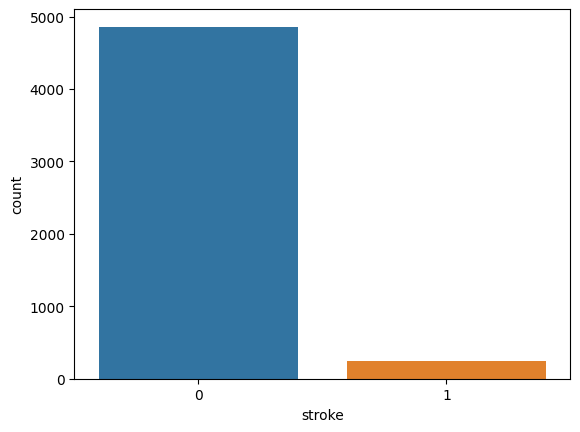

In [4]:
seaborn.countplot(x='stroke', data=data)
# pyplot.savefig("./class_distribution.png")
pyplot.show()

In [5]:

# Remove outlier associated with `gender` (only 1 outlier)
data = data[data['gender'] != "Other"]

# Determine by percentage of unique values
categorical_ix = []
numerical_ix = []
n_uniques = data.nunique() #số giá trị khác nhau trong 1 thuộc tính
for col in features:
    percentage = n_uniques[col]/data.shape[0] * 100
    if percentage < 1:
        categorical_ix.append(col)
    else:
        numerical_ix.append(col)
print("Categorical:", categorical_ix)
print("Numerical:", numerical_ix)



Categorical: ['smoking_status', 'gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type']
Numerical: ['age', 'avg_glucose_level', 'bmi']


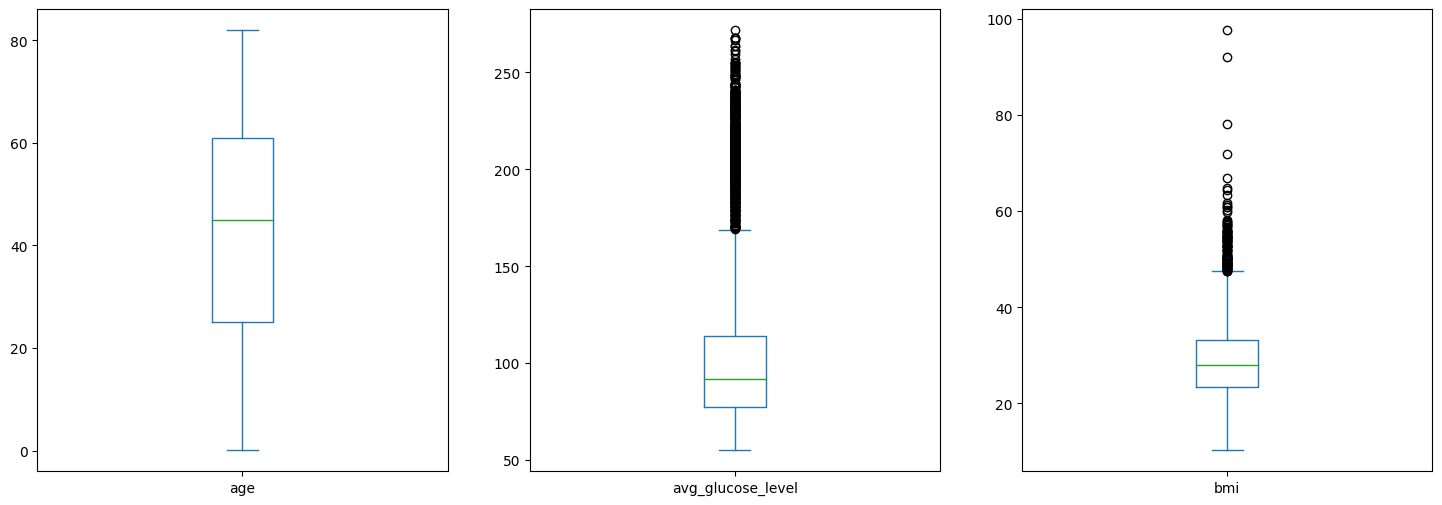

age  avg_glucose_level       bmi
count  5109.000           5109.000  4908.000
mean     43.230            106.140    28.895
std      22.614             45.285     7.854
min       0.080             55.120    10.300
25%      25.000             77.240    23.500
50%      45.000             91.880    28.100
75%      61.000            114.090    33.100
max      82.000            271.740    97.600

In [6]:
# boxplot
data[numerical_ix].plot(kind='box', subplots=True, layout=(1, 3), figsize=(18, 6))
# pyplot.savefig("./exploration_figures/boxplot_before.png")
pyplot.show()
data[numerical_ix].describe()

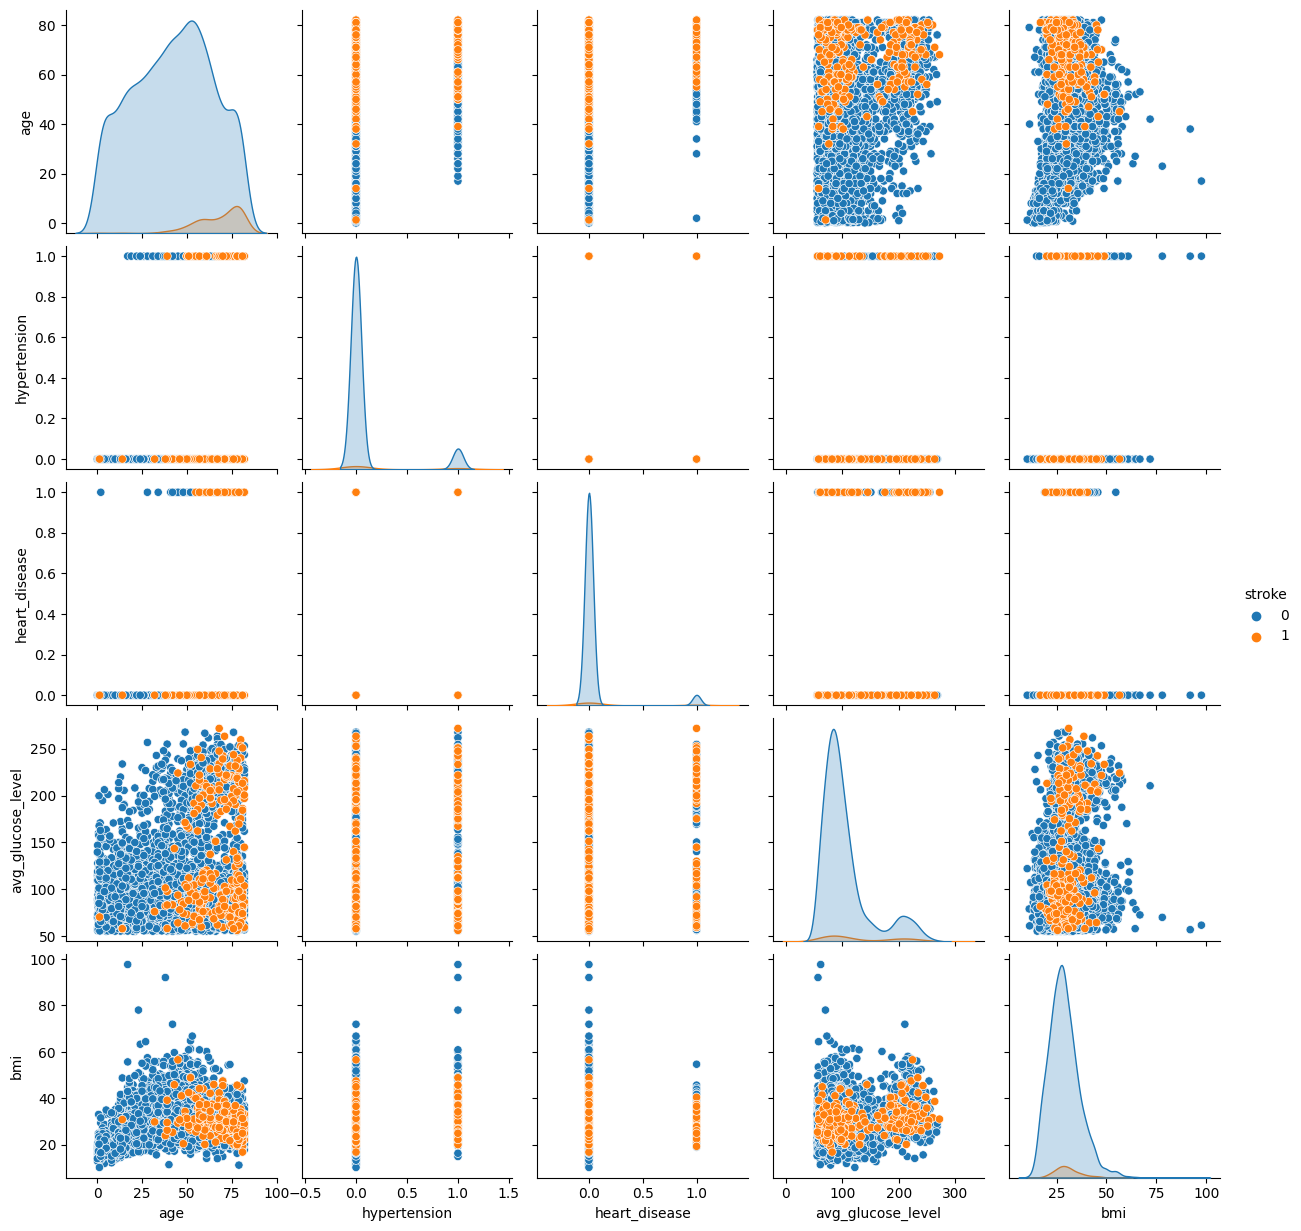

In [7]:
#pairplot
seaborn.pairplot(data.sort_values('stroke'), hue='stroke')
# pyplot.savefig("./exploration_figures/pairplot.png")
pyplot.show()

# 3. Data Cleaning

In [8]:
#Tạo chuỗi boolean cho biết có bị trùng lặp không - True là lặp
dups = data[features].duplicated()
#Truy cập vào data tìm mẫu có kết quả true - đếm, đưa ra kết quả
data[dups].shape[0]

0

In [9]:
outlier_strategy = 'Quantile_Range_Outlier_Detection'
q25, q75 = data['bmi'].quantile(0.25), data['bmi'].quantile(0.75)
iqr = q75 - q25
factor = 4
cut_off = iqr * factor
bmi_upper = q75 + cut_off 
age_lower = 1

# identify non-outlier indexes
#nếu bmi>bmi_upper và age<age_lower thì sẽ là outlier
mask_outlier = (data["bmi"] > bmi_upper) | (data["age"] < age_lower)
mask_nonoutlier = mask_outlier == False #True cho không ngoại lệ và False có ngoại lệ

data = data[mask_nonoutlier].copy() #copy bản không ngoại lệ

# 4. Evaluate Algorithms

In [10]:

test_size = 0.33
X_train, X_test, Y_train, Y_test = train_test_split(data[features], data['stroke'], test_size=test_size, stratify=data['stroke'], random_state=seed)
#sử dụng hàm traim-test-split từ module sklearn.model_selection để chia DL thành tập huấn luyện (train) và tập kiểm tra (test) theo tỉ lệ 2:1

No sampling: 0.153858
ROS (ratio:0.1): 0.157742
ROS (ratio:0.2): 0.149544
ROS (ratio:0.3): 0.142456
ROS (ratio:0.4): 0.128911
ROS (ratio:0.5): 0.129102
ROS (ratio:0.6): 0.124952
ROS (ratio:0.7): 0.113594
ROS (ratio:0.8): 0.129463
ROS (ratio:0.9): 0.126258
No sampling: 0.153858
SMOTE (ratio:0.1): 0.146149
SMOTE (ratio:0.2): 0.148099
SMOTE (ratio:0.3): 0.151595
SMOTE (ratio:0.4): 0.151562
SMOTE (ratio:0.5): 0.144889
SMOTE (ratio:0.6): 0.147957
SMOTE (ratio:0.7): 0.155269
SMOTE (ratio:0.8): 0.141302
SMOTE (ratio:0.9): 0.135237
No sampling: 0.153858
SVMSMOTE (ratio:0.1): 0.153029
SVMSMOTE (ratio:0.2): 0.154895
SVMSMOTE (ratio:0.3): 0.150588
SVMSMOTE (ratio:0.4): 0.139615
SVMSMOTE (ratio:0.5): 0.149228
SVMSMOTE (ratio:0.6): 0.135940
SVMSMOTE (ratio:0.7): 0.149099
SVMSMOTE (ratio:0.8): 0.142241
SVMSMOTE (ratio:0.9): 0.141361
No sampling: 0.153858
BLSMOTE (ratio:0.1): 0.158409
BLSMOTE (ratio:0.2): 0.155783
BLSMOTE (ratio:0.3): 0.147141
BLSMOTE (ratio:0.4): 0.135955
BLSMOTE (ratio:0.5): 0.1357

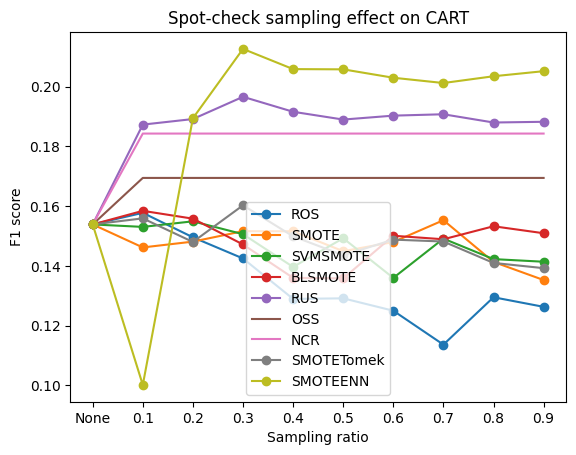

In [11]:

#SimpleImputer - điền giá trị thiếu cho thuộc tính số
#OrdinalEncoder - mã hóa thuộc tính phân loại thành các số

step_trans = ('Trans', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                          ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                         remainder='passthrough'))
#Xây dựng mô hình Cart
step_cart = ('CART', DecisionTreeClassifier(random_state=seed))

ratios = np.arange(0.1, 1, 0.1)
names = ['None'] + [str(round(ratio, 1)) for ratio in ratios]
# print(names)
naive_model = Pipeline([step_trans, step_cart]) #xử lý trước để chuẩn bị DL trước khi áp dụng mô hình

#Sử dụng các kỹ thuật nhân bản DL để xử lý sự mất cân bằng DL trước khi đưa vào mô hình
models = [Pipeline([step_trans,
                    ('ROS', RandomOverSampler(random_state=seed)),
                    step_cart]),
          Pipeline([step_trans,
                    ('SMOTE', SMOTE(random_state=seed)),
                    step_cart]),
          Pipeline([step_trans,
                    ('SVMSMOTE', SVMSMOTE(random_state=seed)),
                    step_cart]),
          Pipeline([step_trans,
                    ('BLSMOTE', BorderlineSMOTE(random_state=seed)),
                    step_cart]),
          Pipeline([step_trans,
                    ('RUS', RandomUnderSampler(random_state=seed)),
                    step_cart]),
          Pipeline([step_trans,
                    ('OSS', OneSidedSelection(random_state=seed)),
                    step_cart]),
          Pipeline([step_trans,
                    ('NCR', NeighbourhoodCleaningRule()),
                    step_cart]),
          Pipeline([step_trans,
                    ('SMOTETomek', SMOTETomek(random_state=seed)),
                    step_cart]),
          Pipeline([step_trans,
                    ('SMOTEENN', SMOTEENN(random_state=seed)),
                    step_cart])
          ]

for model in models:
    cv_results = cross_val_score(naive_model, X_train, Y_train, cv=kfold, scoring=scoring)
    results = [cv_results.mean()]
    print("No sampling: %f" % (cv_results.mean()))

    if model.steps[1][0] != 'OSS' and model.steps[1][0] != 'NCR':
        for ratio in ratios:
            model.steps[1][1].set_params(sampling_strategy=ratio)
            cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
            results.append(cv_results.mean())
            print("%s (ratio:%.1f): %f" % (model.steps[1][0], ratio, cv_results.mean()))
        line = pyplot.plot(names, results, '-o', label=model.steps[1][0])
    else:
        cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
        results.extend([cv_results.mean()] * (len(ratios)))
        print("%s: %f" % (model.steps[1][0], cv_results.mean()))
        line = pyplot.plot(names, results, '-', label=model.steps[1][0])

    # line = pyplot.plot(names, results, '-o', label=model.steps[1][0])
    pyplot.legend()
    pyplot.ylabel('F1 score')
    pyplot.xlabel('Sampling ratio')

pyplot.title("Spot-check sampling effect on CART")
pyplot.show()

Ordinal: 0.212643
... with: n_leaves: 160 	depth: 16
OneHot: 0.214212
... with: n_leaves: 169 	depth: 16


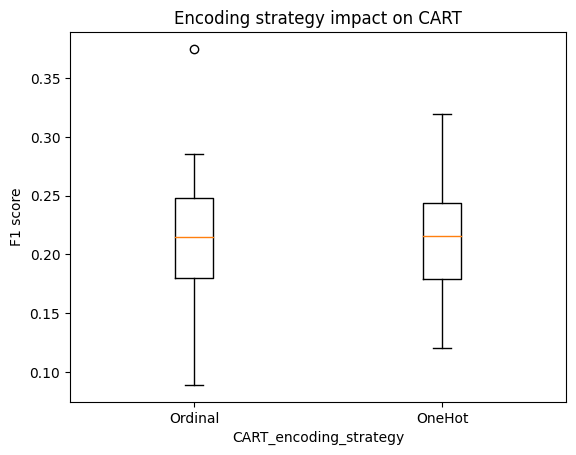

In [12]:

transformers = [('Ordinal', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                               ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                              remainder='passthrough')),
                ('OneHot', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                              ('OneHotEncoder', OneHotEncoder(), categorical_ix)],
                                             remainder='passthrough'))
                ]

step_smote = ('SMOTEENN', SMOTEENN(sampling_strategy=0.3, random_state=seed))
step_cart = ('CART', DecisionTreeClassifier(random_state=seed))

results = []
names = []

for name, transformer in transformers:
    model = Pipeline([('Trans', transformer),
                      step_smote,
                      step_cart])
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print("%s: %f" % (name, cv_results.mean()))

    model.fit(X_train, Y_train)
    print("... with: n_leaves: %d \tdepth: %d" % (model['CART'].get_n_leaves(), model['CART'].get_depth()))

my_boxplot(xlabel='CART_encoding_strategy', data=results, labels=names, ylabel="F1 score", title="Encoding strategy impact on CART", loc='./CART_figures')

After several runs, we notice that SMOTEENN is the most promising. In the next part of notebook, we'll use SMOTEENN with ratio 0.3 as default sampling technique

According to some articles, Onehot encoding is generally more suitable for norminal variables and in Decision Tree model, Ordinal encoding is more suitable.

In our problem, after doing many experiment, we do not any significant different.

# 5. Algorithm Tuning

```
Danh sách các tham số mô hình: 
DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, ccp_alpha=0.0)
```

In [13]:

step_trans = ('Trans', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                          ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                         remainder='passthrough'))
step_smote = ('SMOTEENN', SMOTEENN(sampling_strategy=0.3, random_state=seed))

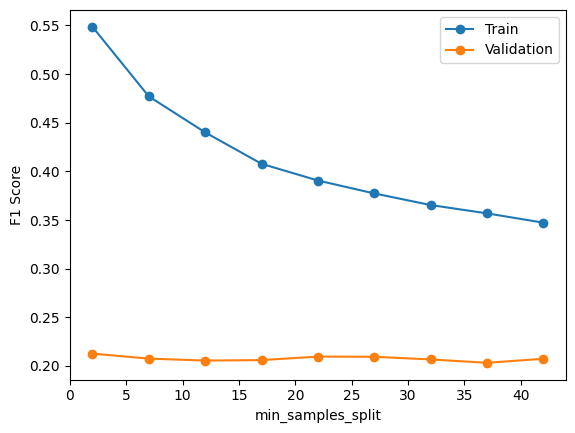

In [14]:

step_cart = ('CART', DecisionTreeClassifier(random_state=seed))

model = Pipeline([step_trans, step_smote, step_cart])

train_results = []
validation_results = []
min_samples_splits = np.arange(2, 43, 5)

for min_samples_split in min_samples_splits:
    model['CART'].set_params(min_samples_split=min_samples_split)
    cv_results = cross_validate(model, X_train, Y_train, cv=kfold, scoring=scoring, return_train_score=True)
    train_results.append(cv_results['train_score'].mean())
    validation_results.append(cv_results['test_score'].mean())

my_lineplot(x=min_samples_splits, y1=train_results, y2=validation_results, label1='Train', label2='Validation', xlabel='min_samples_split', ylabel='F1 Score', title='CART_tune_minsamplessplit', loc='./CART_figures')

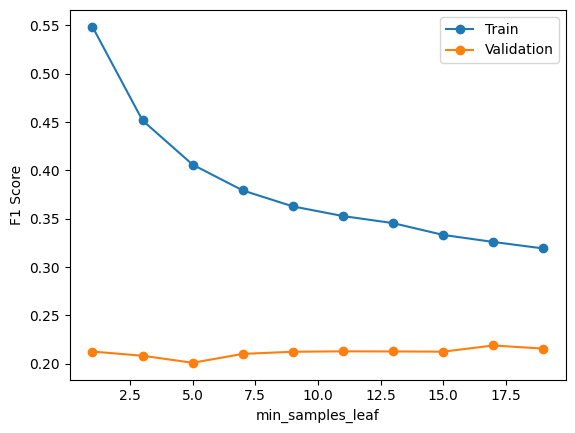

In [15]:

step_cart = ('CART', DecisionTreeClassifier(random_state=seed))

model = Pipeline([step_trans, step_smote, step_cart])

train_results = []
validation_results = []
min_samples_leafs = np.arange(1, 21, 2)

for min_samples_leaf in min_samples_leafs:
    model['CART'].set_params(min_samples_leaf=min_samples_leaf)
    cv_results = cross_validate(model, X_train, Y_train, cv=kfold, scoring=scoring, return_train_score=True)
    train_results.append(cv_results['train_score'].mean())
    validation_results.append(cv_results['test_score'].mean())

my_lineplot(x=min_samples_leafs, y1=train_results, y2=validation_results, label1='Train', label2='Validation', xlabel='min_samples_leaf', ylabel='F1 Score', title='CART_tune_minleafsplit', loc='./CART_figures')

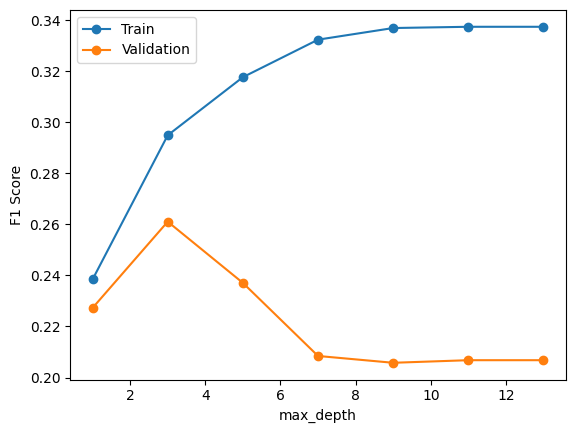

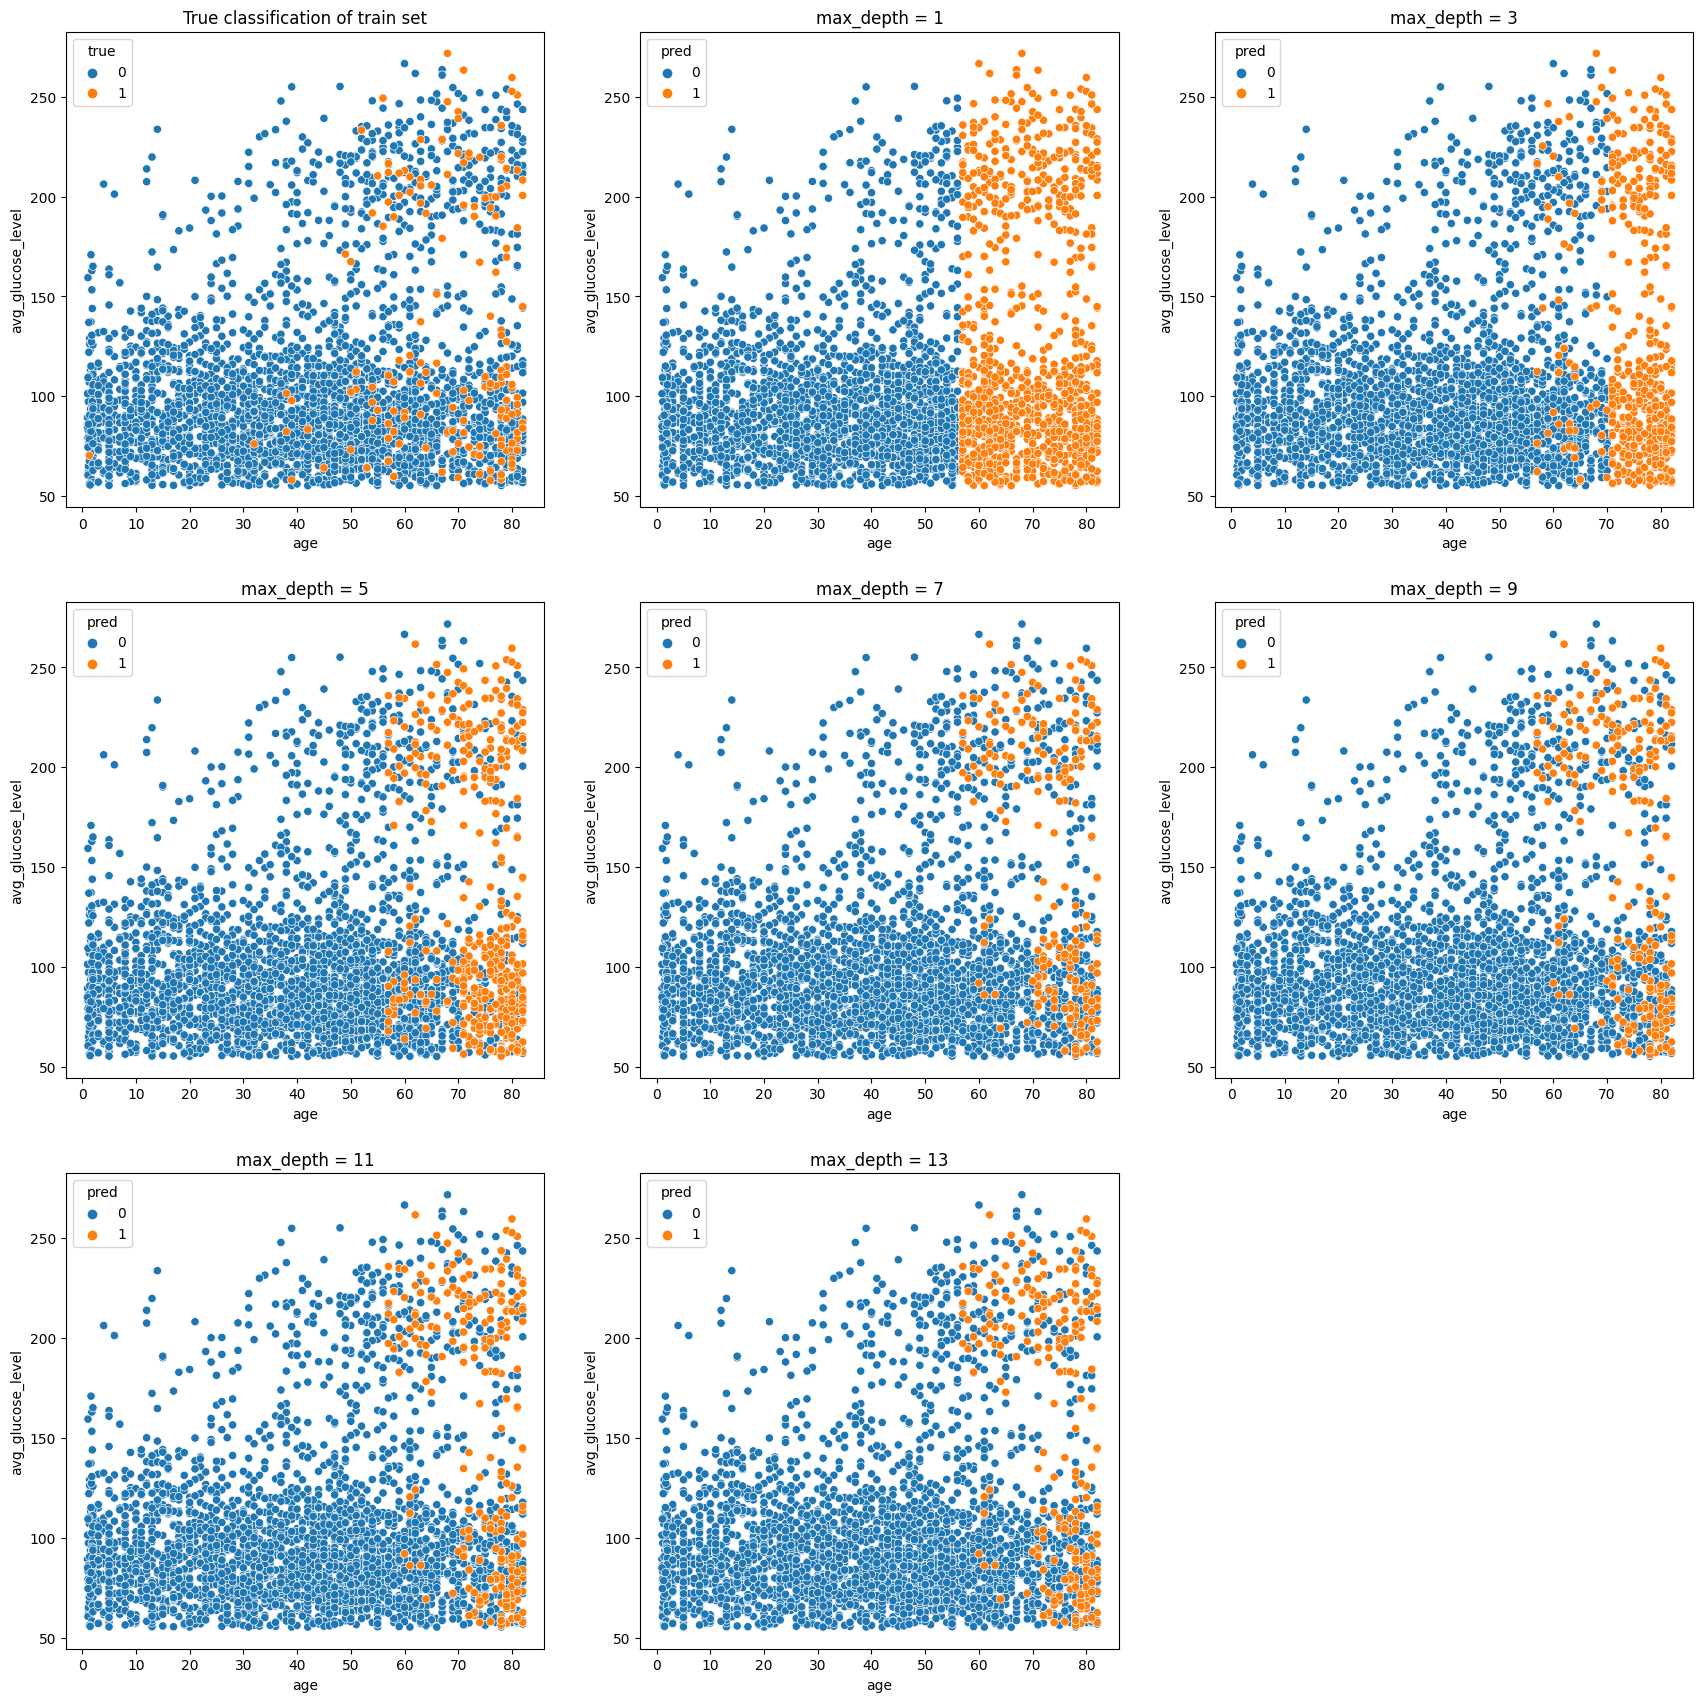

In [16]:
#Giải quyết vấn đề overfit

step_cart = ('CART', DecisionTreeClassifier(random_state=seed, min_samples_split=37, min_samples_leaf=11))

model = Pipeline([step_trans, step_smote, step_cart])

train_results = []
validation_results = []
max_depths = np.arange(1, 15, 2)

for max_depth in max_depths:
    model['CART'].set_params(max_depth=max_depth)
    cv_results = cross_validate(model, X_train, Y_train, cv=kfold, scoring=scoring, return_train_score=True)
    train_results.append(cv_results['train_score'].mean())
    validation_results.append(cv_results['test_score'].mean())

my_lineplot(x=max_depths, y1=train_results, y2=validation_results, label1='Train', label2='Validation', xlabel='max_depth', ylabel='F1 Score', title='CART_tune_maxdepth', loc='./CART_figures')

data_train = X_train.copy()
data_train['true'] = Y_train
data_train.sort_values('true', inplace=True)

pyplot.figure(figsize=(21, 21))
pyplot.subplot(3, 3, 1)
seaborn.scatterplot(data=data_train, x='age', y='avg_glucose_level', hue='true')
pyplot.title('True classification of train set')

i = 2
for max_depth in max_depths:
    model['CART'].set_params(max_depth=max_depth)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_train)

    data_train = X_train.copy()

    data_train['pred'] = Y_pred
    data_train.sort_values('pred', inplace=True)
    pyplot.subplot(3, 3, i)
    seaborn.scatterplot(data=data_train, x='age', y='avg_glucose_level', hue='pred')
    pyplot.title('max_depth = ' + str(max_depth))
    i += 1

pyplot.savefig('./CART_figures/CART_maxdepth.png')
pyplot.show()

As we can see in the figure, the model predicts fairly well on train set as `max_depth` increases, but fails on new data.

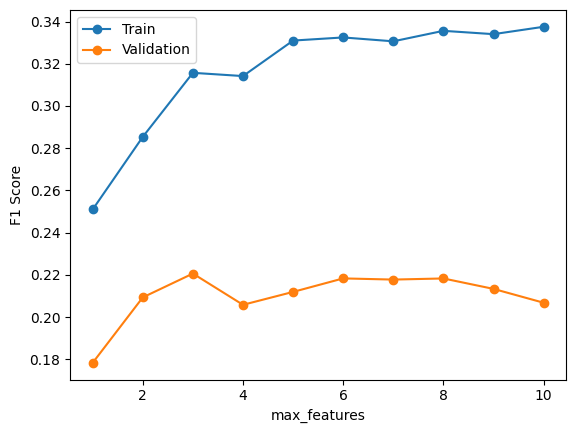

In [17]:

step_cart = ('CART', DecisionTreeClassifier(random_state=seed, min_samples_split=37, min_samples_leaf=11))

model = Pipeline([step_trans, step_smote, step_cart])

train_results = []
validation_results = []
max_featuress = np.arange(1, 11, 1)

for max_features in max_featuress:
    model['CART'].set_params(max_features=max_features)
    cv_results = cross_validate(model, X_train, Y_train, cv=kfold, scoring=scoring, return_train_score=True)
    train_results.append(cv_results['train_score'].mean())
    validation_results.append(cv_results['test_score'].mean())

my_lineplot(x=max_featuress, y1=train_results, y2=validation_results, label1='Train', label2='Validation', xlabel='max_features', ylabel='F1 Score', title='CART_tune_maxfeatures', loc='./CART_figures')

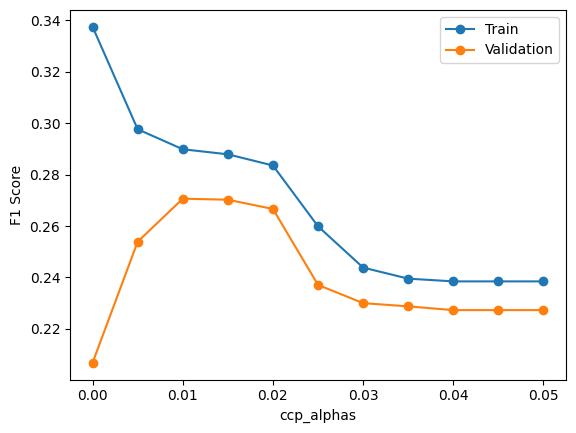

In [18]:

step_cart = ('CART', DecisionTreeClassifier(random_state=seed, min_samples_split=37, min_samples_leaf=11))

model = Pipeline([step_trans, step_smote, step_cart])

train_results = []
validation_results = []
ccp_alphas = np.arange(0, 0.051, 0.005)

for ccp_alpha in ccp_alphas:
    model['CART'].set_params(ccp_alpha=ccp_alpha)
    cv_results = cross_validate(model, X_train, Y_train, cv=kfold, scoring=scoring, return_train_score=True)
    train_results.append(cv_results['train_score'].mean())
    validation_results.append(cv_results['test_score'].mean())

my_lineplot(x=ccp_alphas, y1=train_results, y2=validation_results, label1='Train', label2='Validation', xlabel='ccp_alphas', ylabel='F1 Score', title='CART_tune_ccpalpha', loc='./CART_figures')

ccp_alpha (0.001): 0.334975
ccp_alpha (0.002): 0.301994
ccp_alpha (0.003): 0.295425
ccp_alpha (0.004): 0.295425
ccp_alpha (0.005): 0.295425
ccp_alpha (0.006): 0.290954
ccp_alpha (0.007): 0.290954
ccp_alpha (0.008): 0.291725


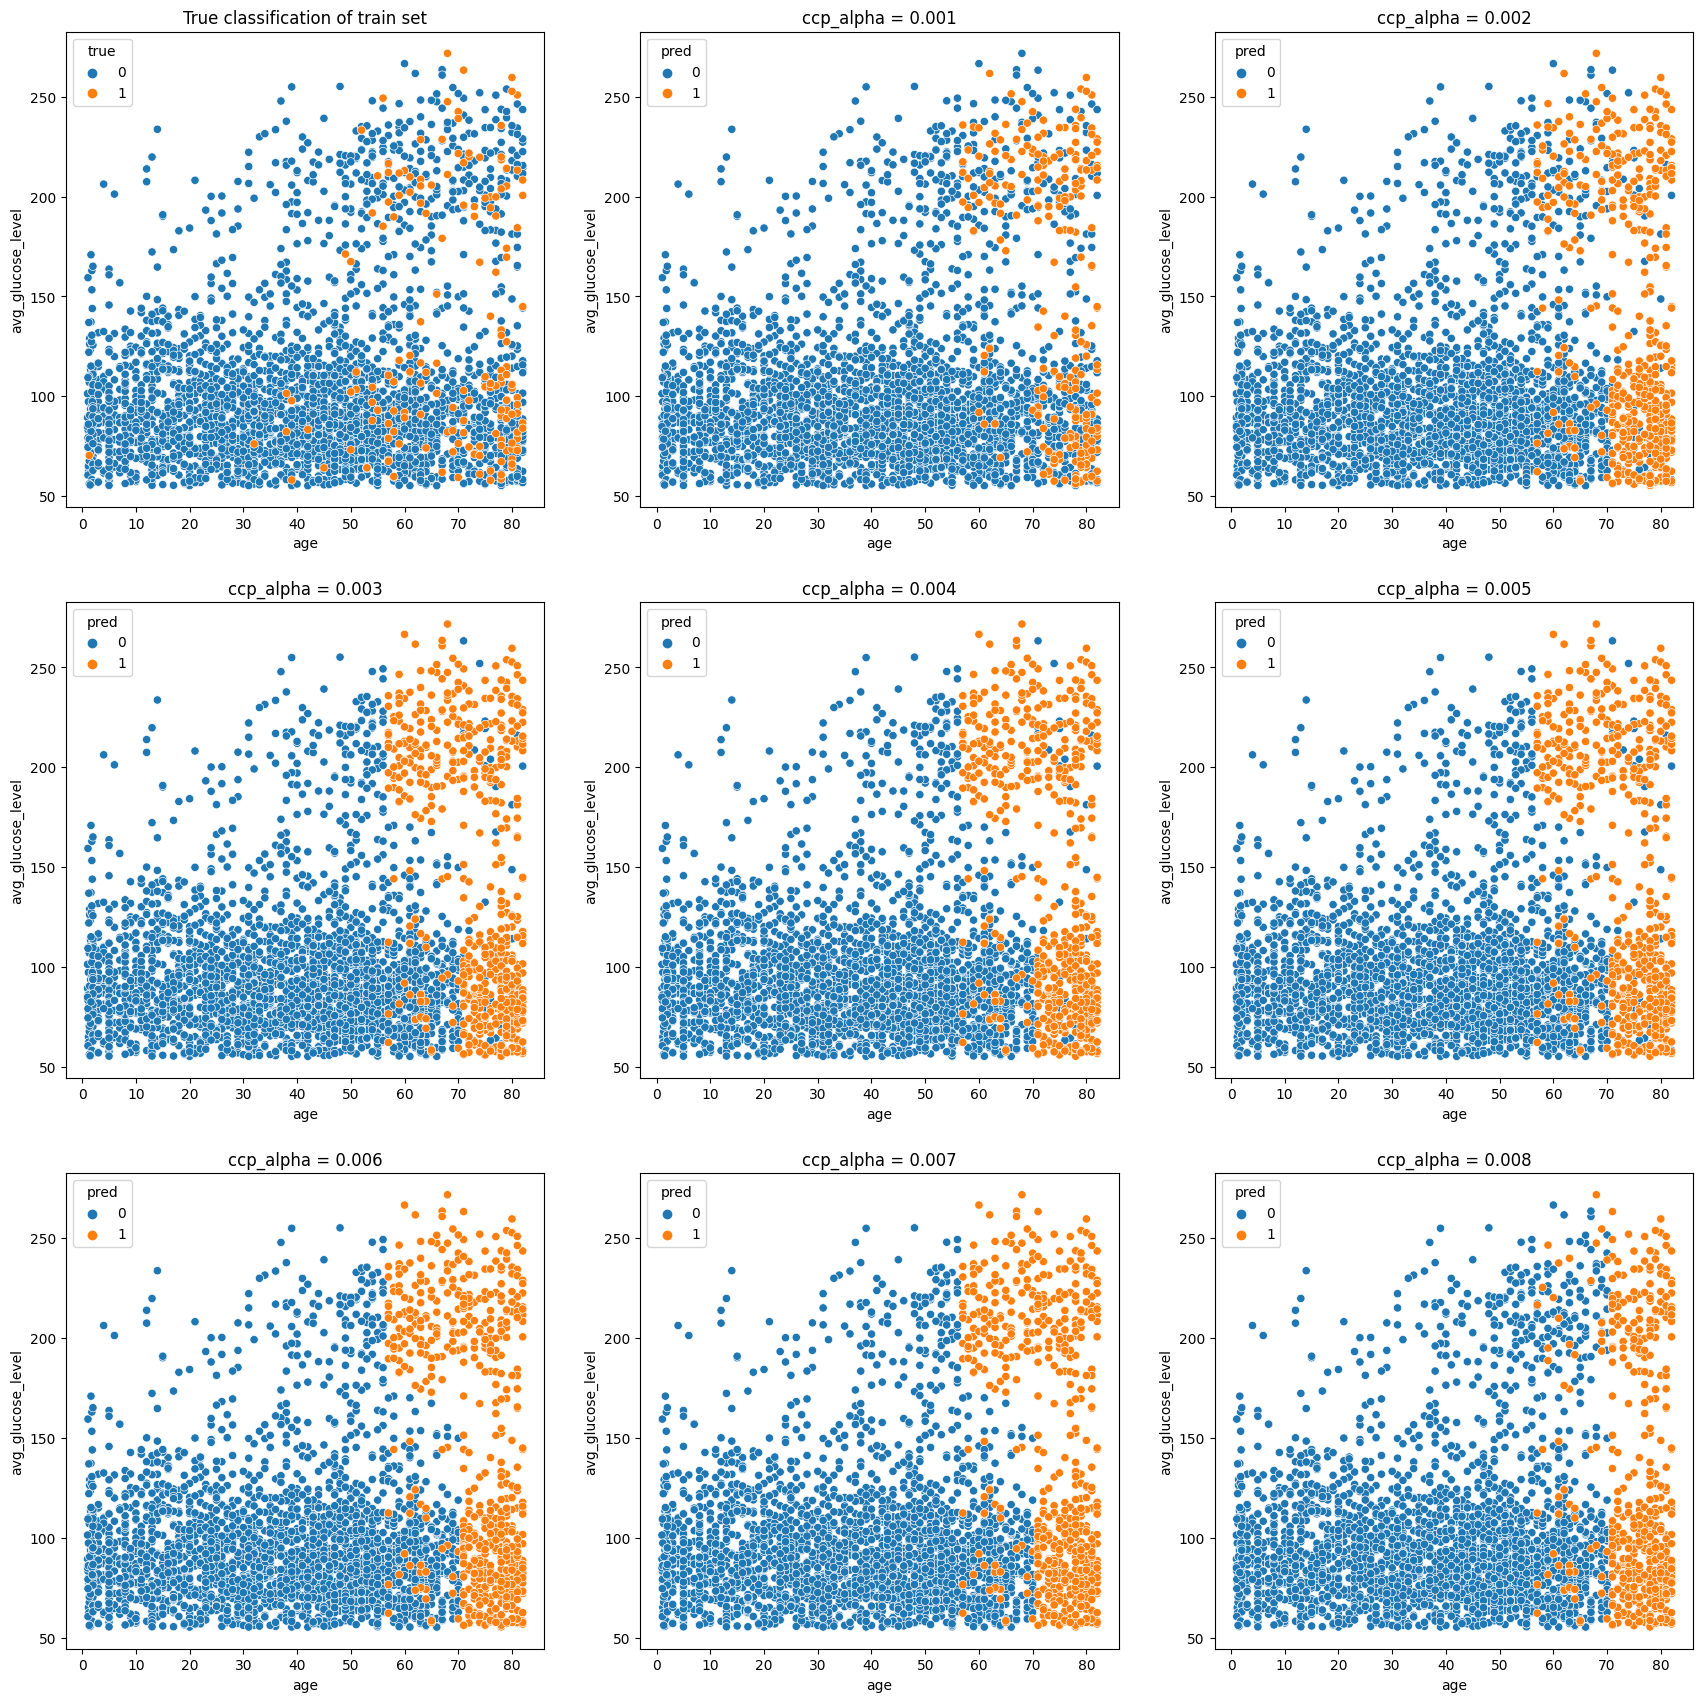

In [19]:

step_cart = ('CART', DecisionTreeClassifier(random_state=seed, min_samples_split=37, min_samples_leaf=11))

model = Pipeline([step_trans, step_smote, step_cart])

ccp_alphas = np.arange(0.001, 0.009, 0.001)

data_train = X_train.copy()
data_train['true'] = Y_train
data_train.sort_values('true', inplace=True)

pyplot.figure(figsize=(21, 21))
pyplot.subplot(3, 3, 1)
seaborn.scatterplot(data=data_train, x='age', y='avg_glucose_level', hue='true')
pyplot.title('True classification of train set')

i = 2
for ccp_alpha in ccp_alphas:
    model['CART'].set_params(ccp_alpha=ccp_alpha)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_train)
    print("ccp_alpha (%.3f): %f" % (ccp_alpha, f1_score(Y_train, Y_pred)))

    data_train = X_train.copy()

    data_train['pred'] = Y_pred
    data_train.sort_values('pred', inplace=True)
    pyplot.subplot(3, 3, i)
    seaborn.scatterplot(data=data_train, x='age', y='avg_glucose_level', hue='pred')
    pyplot.title('ccp_alpha = ' + str(ccp_alpha))
    i += 1

pyplot.savefig('./CART_figures/CART_ccpalpha.png')
pyplot.show()

Though the performance lifts significantly, the figure above suggests a cautious if we rely on the model. Almost all instances in the right hand is misclassified, which is probably not real.

# 6. Finalizing

CART training time: 0.39377403259277344s
CART predicting time: 0.021990060806274414s
[[1487  102]
 [  57   25]]
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1589
           1       0.20      0.30      0.24        82

    accuracy                           0.90      1671
   macro avg       0.58      0.62      0.59      1671
weighted avg       0.93      0.90      0.91      1671



C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


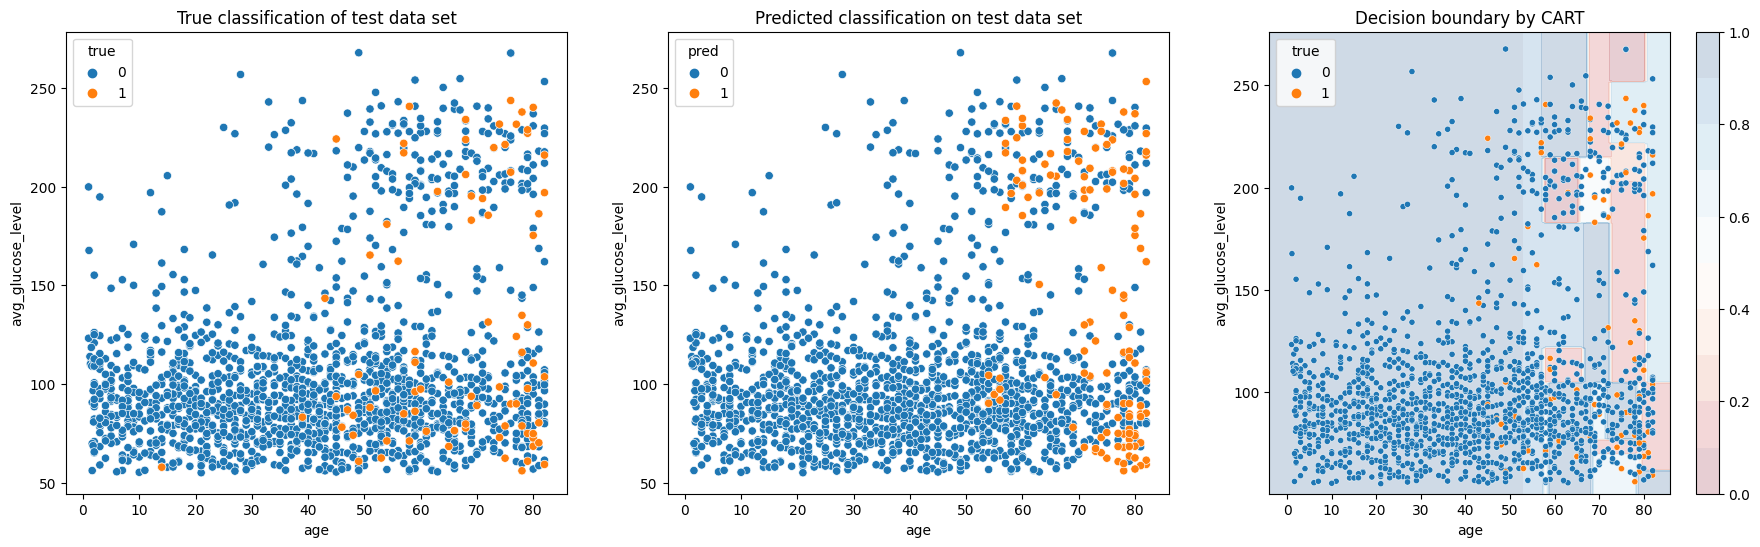

In [20]:

start_train = time.time()

step_trans = ('Trans', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                          ('OneHotEncoder', OneHotEncoder(), categorical_ix)],
                                         remainder='passthrough'))
step_smote = ('SMOTEENN', SMOTEENN(sampling_strategy=0.3, random_state=seed))
step_cart = ('CART', DecisionTreeClassifier(random_state=seed, min_samples_split=37, min_samples_leaf=11, ccp_alpha=0.001))

cart = Pipeline([step_trans, step_smote, step_cart])

# prepare the model
cart.fit(X_train, Y_train)
end_train = time.time()

# estimate on the test dataset
start_pred = time.time()
Y_pred = cart.predict(X_test)
end_pred = time.time()
print("CART training time: %ss" % (end_train - start_train))
print("CART predicting time: %ss" % (end_pred - start_pred))
print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

data_test = X_test.copy()
data_test['true'] = Y_test
data_test['pred'] = Y_pred
data_test.sort_values('true', inplace=True)

pyplot.figure(figsize=(22, 6))
pyplot.subplot(1, 3, 1)
seaborn.scatterplot(data=data_test, x='age', y='avg_glucose_level', hue='true')
pyplot.title('True classification of test data set')

data_test.sort_values('pred', inplace=True)
pyplot.subplot(1, 3, 2)
seaborn.scatterplot(data=data_test, x='age', y='avg_glucose_level', hue='pred')
pyplot.title('Predicted classification on test data set')

# visualize
model = Pipeline([step_smote,
                  step_cart])
pyplot.subplot(1, 3, 3)
visualize_boundary(model, X_train, Y_train)

pyplot.title('Decision boundary by CART')
pyplot.savefig("./CART_figures/CART_final_prediction.png")
pyplot.show()

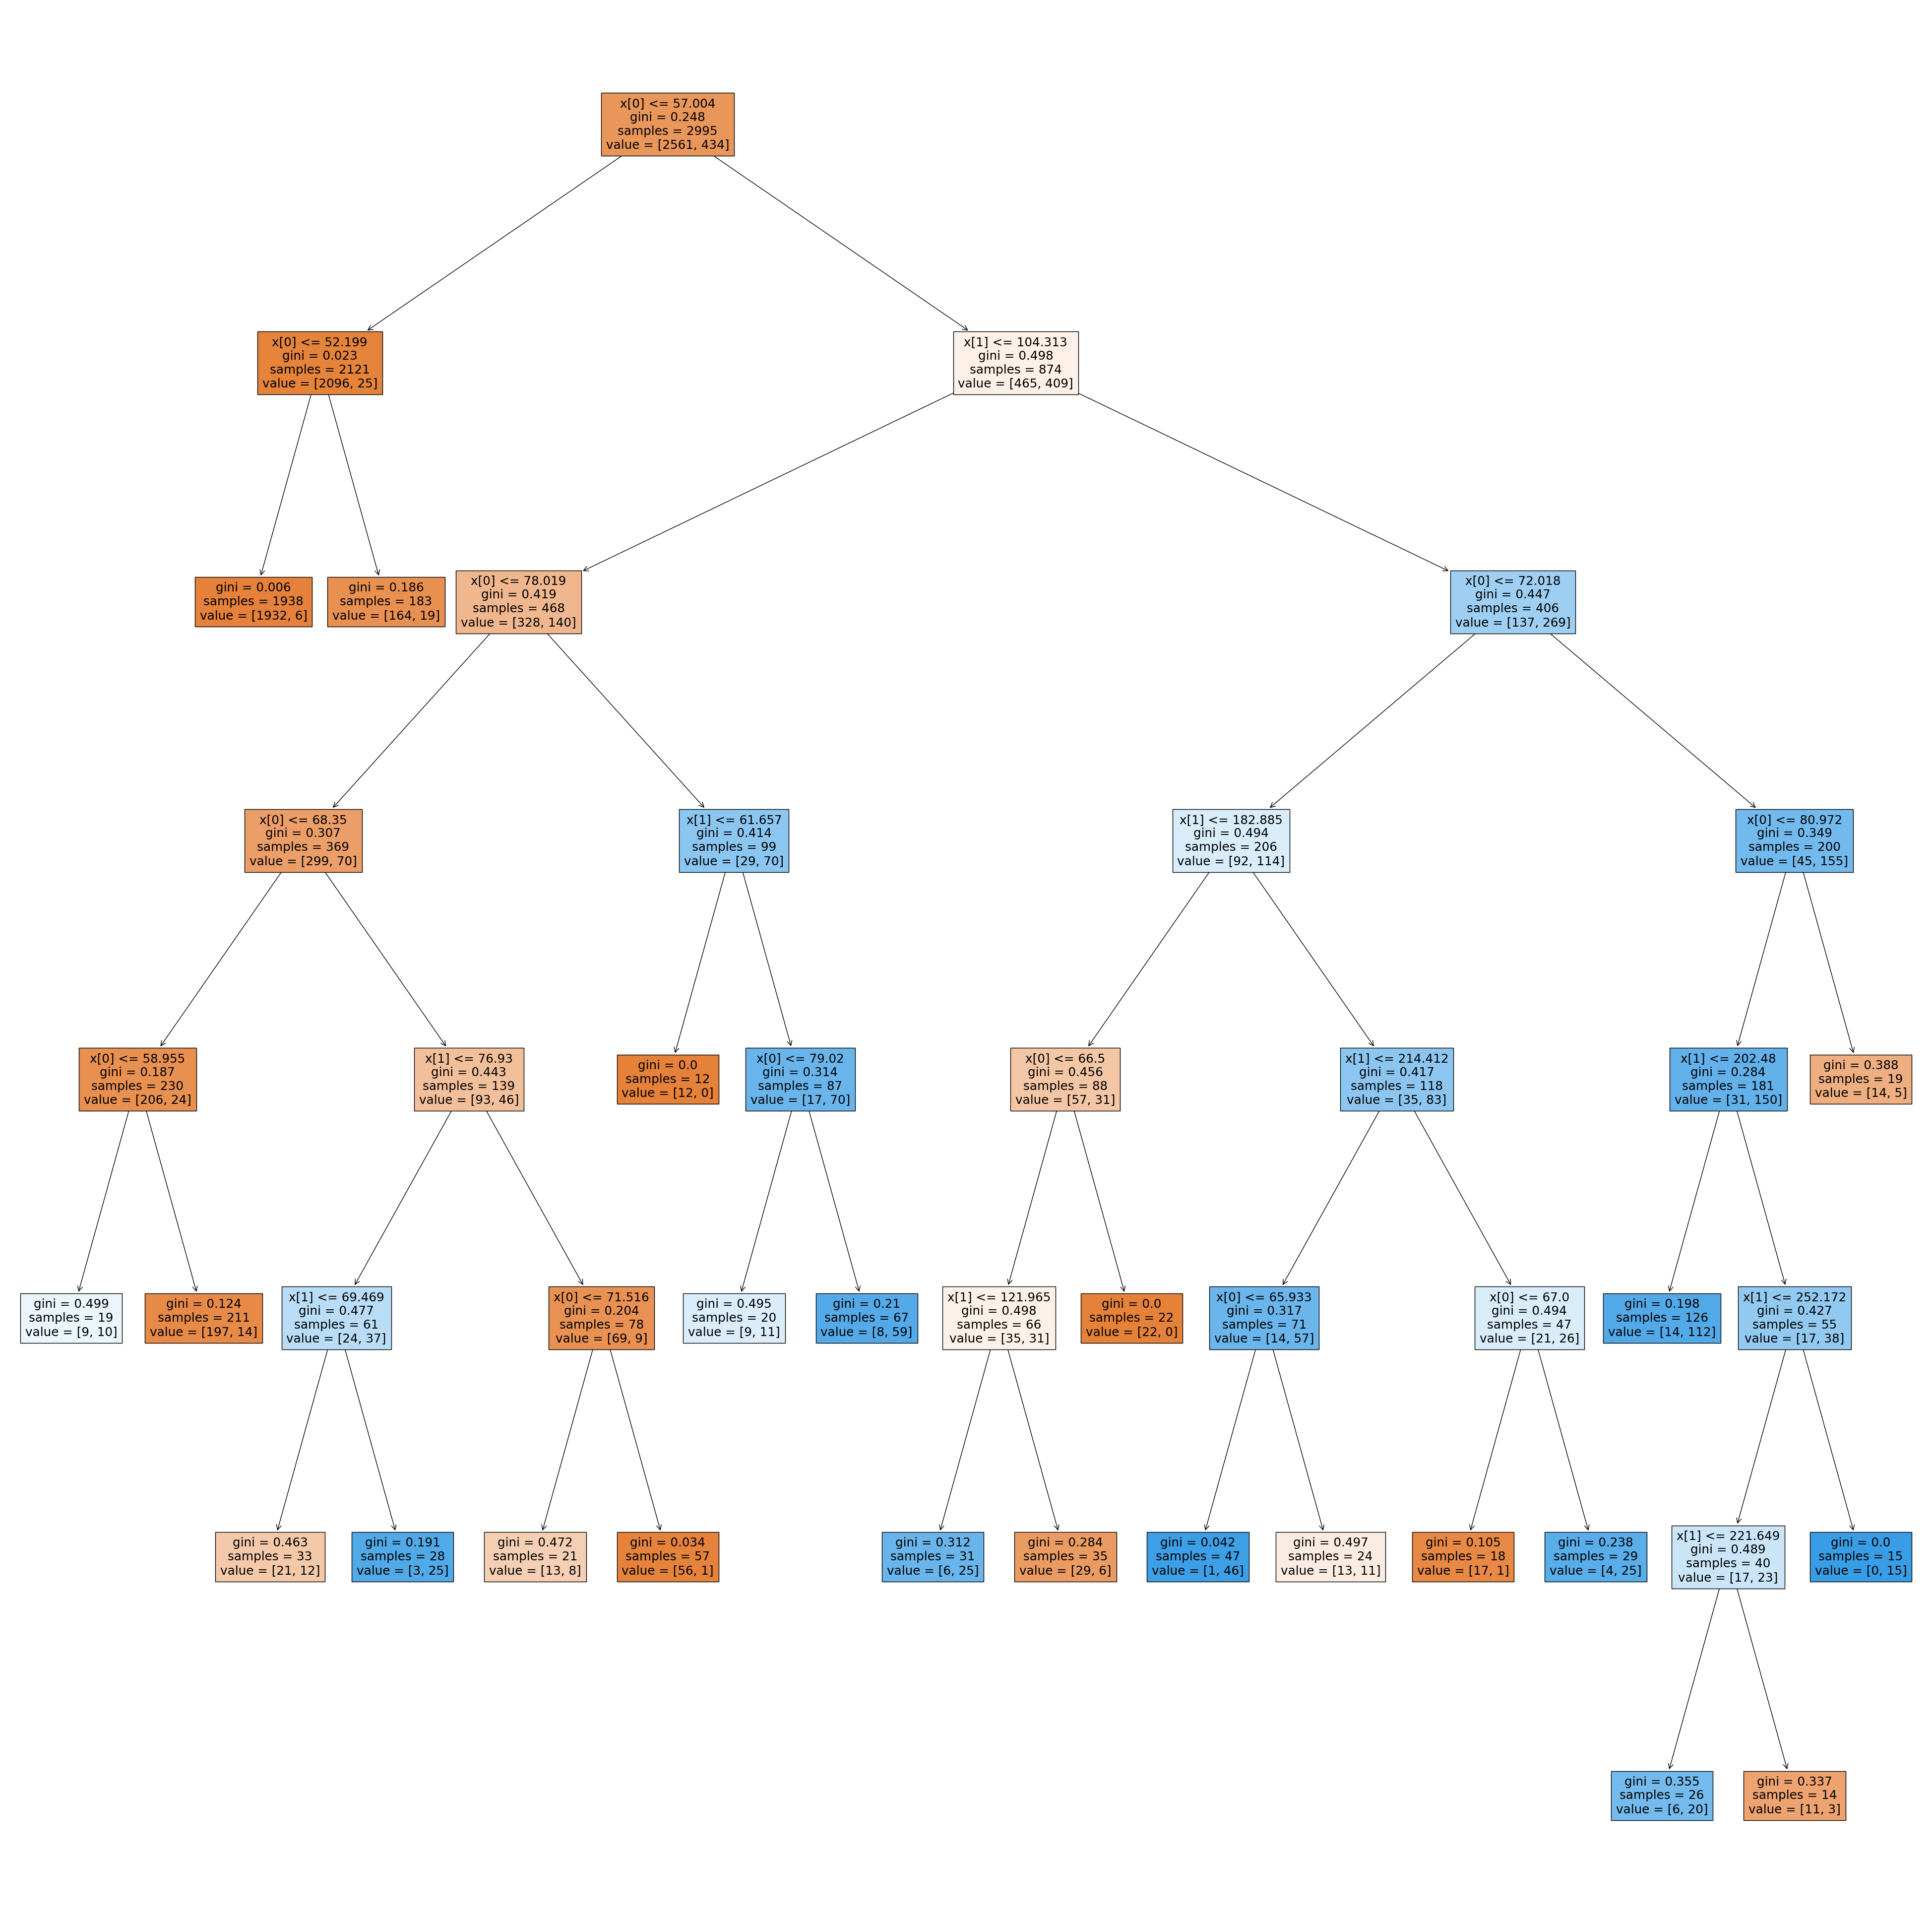

In [21]:

pyplot.figure(figsize=(50, 50))
tree.plot_tree(cart['CART'], filled=True)
pyplot.savefig('./CART_figures/CART_visualize.png')
pyplot.show()

## 6.2 Save model for later use

In [22]:

dump(cart, open('cart.pkl', 'wb'))

In [23]:

model = load(open('cart.pkl', 'rb'))